# Tweet Sentiment Analysis

## Importing Libraries

In [16]:
import pandas as pd 
import numpy as np 
import re 
import string 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
import nltk

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier

In [110]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# import warnings
# warnings.filterwarnings('ignore') 

Stopwords

In [7]:
stop_words=set(stopwords.words('english'))

In [31]:
train=pd.read_csv('train.csv')

In [32]:
train

,Id,Category,Tweet
0,635769805279248384,negative,Not Available
1,635930169241374720,neutral,IOS 9 App Transport Security. Mm need to check...
2,635950258682523648,neutral,"Mar if you have an iOS device, you should down..."
3,636030803433009153,negative,@jimmie_vanagon my phone does not run on lates...
4,636100906224848896,positive,Not sure how to start your publication on iOS?...
...,...,...,...
5965,639016598477651968,neutral,@YouAreMyArsenal Wouldn't surprise me if we en...
5966,640276909633486849,neutral,Rib injury for Zlatan against Russia is a big ...
5967,640296841725235200,neutral,Noooooo! I was hoping to see Zlatan being Zlat...
5968,641017384908779520,neutral,Not Available


In [33]:
train.describe()

,Id,Category,Tweet
count,5970,5970,5970
unique,5964,4,5418
top,641616155619258368,positive,Not Available
freq,2,2888,548


In [34]:
train['Category'].value_counts()

positive    2888
neutral     2125
negative     956
Tweet          1
Name: Category, dtype: int64

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5970 entries, 0 to 5969
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        5970 non-null   object
 1   Category  5970 non-null   object
 2   Tweet     5970 non-null   object
dtypes: object(3)
memory usage: 140.0+ KB


In [36]:
train['Category']

0       negative
1        neutral
2        neutral
3       negative
4       positive
          ...   
5965     neutral
5966     neutral
5967     neutral
5968     neutral
5969     neutral
Name: Category, Length: 5970, dtype: object

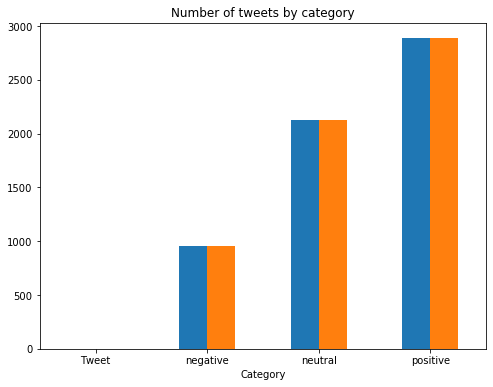

In [37]:
train.groupby(['Category']).count().plot(kind='bar', figsize=(8, 6), rot=0, legend=False, title='Number of tweets by category');


In [38]:
train[train['Category']=='Tweet']

,Id,Category,Tweet
5929,Id,Tweet,Category


In [39]:
rtrain=train[train.Category!='Tweet']

In [40]:
rtrain=rtrain[rtrain.Tweet!='Not Available']

In [41]:
rtrain

,Id,Category,Tweet
1,635930169241374720,neutral,IOS 9 App Transport Security. Mm need to check...
2,635950258682523648,neutral,"Mar if you have an iOS device, you should down..."
3,636030803433009153,negative,@jimmie_vanagon my phone does not run on lates...
4,636100906224848896,positive,Not sure how to start your publication on iOS?...
5,636176272947744772,neutral,"Two Dollar Tuesday is here with Forklift 2, Qu..."
...,...,...,...
5963,638445576212754433,positive,"Ok ed let's do this, Zlatan, greizmann and Lap..."
5964,638531837313306624,neutral,Goal level: Zlatan 90k by Friday? = Posting e...
5965,639016598477651968,neutral,@YouAreMyArsenal Wouldn't surprise me if we en...
5966,640276909633486849,neutral,Rib injury for Zlatan against Russia is a big ...


In [42]:
le = LabelEncoder()
rtrain['target'] = le.fit_transform(rtrain['Category'])


#### Text_Processing

In [43]:
def text_processing(tweet):
    tweet = tweet.lower()
    
    tweet=re.sub(r"http\S+|www\S+|https\S+","",tweet,flags=re.MULTILINE)
    
    tweet = re.sub(r'\@\w+|\#'," ",tweet)
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in tweet if char not in string.punctuation]
    
    # Join the characters again to form the string.
    tweet = ''.join(nopunc)
    
    tweet_tokens= word_tokenize(tweet)
    
    filtered_words=[word for word in tweet_tokens if word not in stop_words]
        
    ps =PorterStemmer()
    stemmed_words=[ps.stem(w) for w in filtered_words]
    
    lem=WordNetLemmatizer()
    lem_words=[lem.lemmatize(w, pos ="a") for w in filtered_words]
    
    return " ".join(lem_words)

text_processing("hello i anfjs ie www.hel.com. #@#@#22j oer")

'hello anfjs ie 22j oer'

Vectorization

In [44]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)      # Defining the vector
    vector.fit(train_fit)                            # fitting the data into the vector
    return vector                                    # returning the vector as function call


In [45]:
rtrain.head()

,Id,Category,Tweet,target
1,635930169241374720,neutral,IOS 9 App Transport Security. Mm need to check...,1
2,635950258682523648,neutral,"Mar if you have an iOS device, you should down...",1
3,636030803433009153,negative,@jimmie_vanagon my phone does not run on lates...,0
4,636100906224848896,positive,Not sure how to start your publication on iOS?...,2
5,636176272947744772,neutral,"Two Dollar Tuesday is here with Forklift 2, Qu...",1


In [48]:
processed_text = rtrain['Tweet'].apply(text_processing)

print("Processed text :: \n\n", processed_text)


Processed text :: 

 1       ios 9 app transport security mm need check 3rd...
2                             mar ios device download app
3       phone run late ios may account problem day tim...
4       sure start publication ios well live helping a...
5       two dollar tuesday forklift 2 quickkey ios sui...
                              ...                        
5963    ok ed lets zlatan greizmann laporte tomorrow m...
5964    goal level zlatan 90k friday posting every day...
5965    wouldnt surprise enquiredhe cant 100 happy pla...
5966    rib injury zlatan russia big blow misses austr...
5967    noooooo hoping see zlatan zlatan tuesday oh we...
Name: Tweet, Length: 5421, dtype: object


In [49]:
tf_vector = get_feature_vector(np.array(rtrain["Tweet"]).ravel())

In [50]:
X = tf_vector.transform(np.array(rtrain["Tweet"]).ravel())     # Predictor Variable
y = np.array(rtrain["target"]).ravel()                           # Target varaible

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Training

####  Multinomial NB

In [97]:
NB_model = MultinomialNB()

NB_model.fit(X_train, y_train)

MultinomialNB()

In [98]:
y_predict_nb = NB_model.predict(X_test)

print("Accuracy Score for Naive Bayes Model is :: ", accuracy_score(y_test, y_predict_nb))


Accuracy Score for Naive Bayes Model is ::  0.5623847572218807


In [100]:
print(classification_report(y_test, y_predict_nb,target_names=le.classes_))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       262
     neutral       0.50      0.28      0.36       553
    positive       0.58      0.94      0.71       812

    accuracy                           0.56      1627
   macro avg       0.36      0.41      0.36      1627
weighted avg       0.46      0.56      0.48      1627



####  Logistic Regression

In [101]:
LR_model = LogisticRegression(solver='lbfgs')
LR_model.fit(X_train, y_train)

LogisticRegression()

In [102]:
y_predict_lr = LR_model.predict(X_test)


In [103]:
print("Classification_Report :: \n\n", classification_report(y_test, y_predict_lr,target_names=le.classes_))

Classification_Report :: 

               precision    recall  f1-score   support

    negative       0.53      0.12      0.19       262
     neutral       0.46      0.48      0.47       553
    positive       0.65      0.79      0.71       812

    accuracy                           0.58      1627
   macro avg       0.54      0.46      0.46      1627
weighted avg       0.56      0.58      0.55      1627



####  Support Vector Machine

In [104]:
SVM_model=SVC()
SVM_model.fit(X_train,y_train)

SVC()

In [105]:
y_predict_svm=SVM_model.predict(X_test)

In [106]:
print("Classification_Report :: \n\n", classification_report(y_test, y_predict_svm,target_names=le.classes_))

Classification_Report :: 

               precision    recall  f1-score   support

    negative       0.55      0.04      0.08       262
     neutral       0.47      0.46      0.46       553
    positive       0.64      0.84      0.72       812

    accuracy                           0.58      1627
   macro avg       0.55      0.45      0.42      1627
weighted avg       0.57      0.58      0.53      1627



####  RandomForestClassifier

In [107]:
Random_Forest_model=RandomForestClassifier(n_estimators=200,criterion='entropy')
Random_Forest_model.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [108]:
y_predict_rf=Random_Forest_model.predict(X_test)

In [109]:
print("Classification_Report :: \n\n", classification_report(y_test, y_predict_rf,target_names=le.classes_))


Classification_Report :: 

               precision    recall  f1-score   support

    negative       0.44      0.09      0.15       262
     neutral       0.48      0.44      0.46       553
    positive       0.64      0.84      0.73       812

    accuracy                           0.58      1627
   macro avg       0.52      0.46      0.44      1627
weighted avg       0.55      0.58      0.54      1627



# xgb

In [115]:
xgbModel = XGBClassifier(n_estimators=1000)

xgbModel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [116]:
y_predict_xgb=xgbModel.predict(X_test)

In [117]:
print("Classification_Report :: \n\n", classification_report(y_test, y_predict_xgb,target_names=le.classes_))

Classification_Report :: 

               precision    recall  f1-score   support

    negative       0.43      0.24      0.31       262
     neutral       0.44      0.50      0.47       553
    positive       0.66      0.70      0.68       812

    accuracy                           0.55      1627
   macro avg       0.51      0.48      0.48      1627
weighted avg       0.55      0.55      0.54      1627



### Grid Search On SVM

In [85]:
from sklearn.model_selection import GridSearchCV

In [86]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 

In [87]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... C=0.1, gamma=1, total=   7.3s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] ................................... C=0.1, gamma=1, total=   7.2s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   6.8s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   6.9s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   7.4s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   6.8s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   7.1s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   7.2s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .

[CV] ................................ C=10, gamma=0.001, total=   2.3s
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total=   2.7s
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total=   2.6s
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total=   2.7s
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total=   2.6s
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total=   2.7s
[CV] C=100, gamma=0.1 ................................................
[CV] ................................. C=100, gamma=0.1, total=   2.7s
[CV] C=100, gamma=0.1 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  6.0min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             verbose=2)

In [88]:
grid_predictions = grid.predict(X_test)

In [89]:
print(classification_report(y_test,grid_predictions,target_names=le.classes_`))

              precision    recall  f1-score   support

           0       0.51      0.14      0.22       262
           1       0.45      0.50      0.47       553
           2       0.65      0.76      0.70       812

    accuracy                           0.57      1627
   macro avg       0.54      0.47      0.47      1627
weighted avg       0.56      0.57      0.55      1627



### Testing 

In [61]:
test=pd.read_csv('test.csv')

In [68]:
test

,Id,Category
0,628949369883000832,dear @Microsoft the newOoffice for Mac is grea...
1,628976607420645377,@Microsoft how about you make a system that do...
2,629023169169518592,Not Available
3,629179223232479232,Not Available
4,629186282179153920,If I make a game as a #windows10 Universal App...
...,...,...
3995,641411385700712448,I am assembling an epic Pancake Posse for an I...
3996,641452712098406400,do you work at Ihop tomorrow @carlysunshine_
3997,635369700298498048,23 Aug 00;30 #771NAS Rescue193 returned from T...
3998,635769805279248384,Not Available


In [69]:
rtest=test[test.Category!='Not Available']
rtest

,Id,Category
0,628949369883000832,dear @Microsoft the newOoffice for Mac is grea...
1,628976607420645377,@Microsoft how about you make a system that do...
4,629186282179153920,If I make a game as a #windows10 Universal App...
5,629226490152914944,"Microsoft, I may not prefer your gaming branch..."
6,629345637155360768,@MikeWolf1980 @Microsoft I will be downgrading...
...,...,...
3994,641371402348679168,Anybody with a Steak &amp; Shake or IHOP move ...
3995,641411385700712448,I am assembling an epic Pancake Posse for an I...
3996,641452712098406400,do you work at Ihop tomorrow @carlysunshine_
3997,635369700298498048,23 Aug 00;30 #771NAS Rescue193 returned from T...


In [71]:
rtest.columns=['Id','Tweet']
rtest

,Id,Tweet
0,628949369883000832,dear @Microsoft the newOoffice for Mac is grea...
1,628976607420645377,@Microsoft how about you make a system that do...
4,629186282179153920,If I make a game as a #windows10 Universal App...
5,629226490152914944,"Microsoft, I may not prefer your gaming branch..."
6,629345637155360768,@MikeWolf1980 @Microsoft I will be downgrading...
...,...,...
3994,641371402348679168,Anybody with a Steak &amp; Shake or IHOP move ...
3995,641411385700712448,I am assembling an epic Pancake Posse for an I...
3996,641452712098406400,do you work at Ihop tomorrow @carlysunshine_
3997,635369700298498048,23 Aug 00;30 #771NAS Rescue193 returned from T...


In [90]:
rtest.Tweet = rtest["Tweet"].apply(text_processing)

test_feature = tf_vector.transform(np.array(rtest['Tweet']).ravel())

C:\Users\91750\Anaconda\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [91]:
test_prediction_rf = Random_Forest_model.predict(test_feature)

test_prediction_rf

array([2, 1, 2, ..., 2, 1, 1])

### Final Result 

In [94]:

submission_result_rf = pd.DataFrame({'tweet_id': rtest.Id, 'tweet':rtest.Tweet ,'sentiment':test_prediction_rf})
submission_result_rf

,tweet_id,tweet,sentiment
0,628949369883000832,dear newooffice mac great lync update cmon,2
1,628976607420645377,make system doesnt eat friggin discs 2nd time ...,1
4,629186282179153920,make game windows10 universal app xboxone owne...,2
5,629226490152914944,microsoft may prefer gaming branch business ma...,1
6,629345637155360768,downgrading let windows10 almost 1st yr b4 try...,2
...,...,...,...
3994,641371402348679168,anybody steak amp shake ihop move tomorrow,2
3995,641411385700712448,assembling epic pancake posse ihop run thursda...,1
3996,641452712098406400,work ihop tomorrow,2
3997,635369700298498048,23 aug 0030 771nas rescue193 returned tresco i...,1


In [95]:

test_result2 = submission_result_rf['sentiment'].value_counts()
test_result2

2    2043
1    1589
0       8
Name: sentiment, dtype: int64